In [1]:
#Import Modules
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.helpers import write_geotiff

sys.path.append('/g/data/u46/users/ck9738/10_Scripts')
import TasseledCapTools

dc = datacube.Datacube(app='tcw')

%load_ext autoreload

%autoreload 2

In [2]:
#define area of interest
query = {
    
        #Tanbar QLD
# 'y': (-26.141, -26.269),
# 'x': (141.482, 141.669), 
   
        #Tuross Head
# 'y': (-36.01, -36.092),
# 'x': (150.047, 150.186), 
    
    #Pambula wetlands
'y': (-36.924, -36.988),
'x': (149.848, 149.925), 
    
# #ever lasting swamp
# 'y': (-29.365, -29.489),
# 'x': (153.033, 153.200),
    
    
#lake Coleman
# 'y': (-38.103, -38.259),
# 'x': (147.098, 147.421),

         #Macquarie Marshes
# 'y': (-30.512, -30.977),
# 'x': (147.413, 147.809),
    
#     #Daintree Rainforrest
# 'y': (-16.140, -16.209),
# 'x': (145.394, 145.460),    

    
    #Big Gunbower
# 'y': (-35.636, -35.905),
# 'x': (144.102, 144.387),
    
# jerrabombera wetland
#'y': (-35.288, -35.346),
#'x': (149.139, 149.191),

#ACT
# 'y': (-35.270, -35.336),
# 'x': (149.021, 149.194),    

#ACT LArge
# 'y': (-35.216, -35.414),
# 'x': (149.040, 149.309),      
    
    #lake george
# 'y': (-34.957, -35.221),
# 'x': (149.294, 149.519),   
    
#Kowen
# 'y': (-35.269, -35.354),
# 'x': (149.239, 149.396),   
    
#gunbower
# 'y': (-35.743, -35.909),
# 'x': (144.235, 144.387),
    
    
'time': ('2018-01-01', '2018-12-30'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (-25, 25)
}
    

In [3]:
#load data
data_lst8 = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query)
data_lst8

<xarray.Dataset>
Dimensions:          (time: 46, x: 313, y: 320)
Coordinates:
  * time             (time) datetime64[ns] 2018-01-03T23:45:03 ... 2018-12-28T23:50:34
  * y                (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x                (x) float64 1.589e+06 1.589e+06 ... 1.597e+06 1.597e+06
Data variables:
    coastal_aerosol  (time, y, x) int16 251 294 327 321 ... 8800 8708 8677 8537
    blue             (time, y, x) int16 175 222 245 239 ... 8347 8275 8217 8092
    green            (time, y, x) int16 297 327 340 304 ... 8534 8298 8279 8207
    red              (time, y, x) int16 190 225 258 261 ... 8537 8346 8359 8203
    nir              (time, y, x) int16 2713 2529 2356 2074 ... 8537 8507 8331
    swir1            (time, y, x) int16 1002 1167 1232 1054 ... 3763 3775 3912
    swir2            (time, y, x) int16 454 483 552 497 ... 3138 2899 3007 3098
Attributes:
    crs:      EPSG: 3577

In [4]:
#define number of total observations

total_obs = int(len(data_lst8.time))
total_obs

46

In [5]:
#turn terrain masked values form -999 to Nan

want_to_mask = (data_lst8 == -999).to_array(dim='variables').all(dim='variables')
terrain_out = data_lst8.copy(deep=True).where(~want_to_mask, np.NaN)

In [6]:
#load PG
sensor_pq = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)
sensor_pq

<xarray.Dataset>
Dimensions:       (time: 46, x: 313, y: 320)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-03T23:45:03 ... 2018-12-28T23:50:34
  * y             (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x             (x) float64 1.589e+06 1.589e+06 ... 1.597e+06 1.597e+06
Data variables:
    pixelquality  (time, y, x) int16 16383 16383 16383 ... 12799 12799 12799
Attributes:
    crs:      EPSG: 3577

In [7]:
#Mask Cloud

#make Mask
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)
good_quality

<xarray.DataArray 'pixelquality' (time: 46, y: 320, x: 313)>
array([[[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       [[ True, False, ...,  True,  True],
        [ True, False, ..., False, False],
        ...,
        [False, False, ...,  True, False],
        [False, False, ...,  True,  True]],

       ...,

       [[ True,  True, ..., False, False],
        [ True,  True, ..., False, False],
        ...,
        [False, False, ..., False,  True],
        [False, False, ...,  True,  True]],

       [[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-03T23:45:03 ... 2018-12-28T23:50:34
  * y        (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x        

In [8]:
#apply Mask
Masked_lst8_data = terrain_out.where(good_quality)

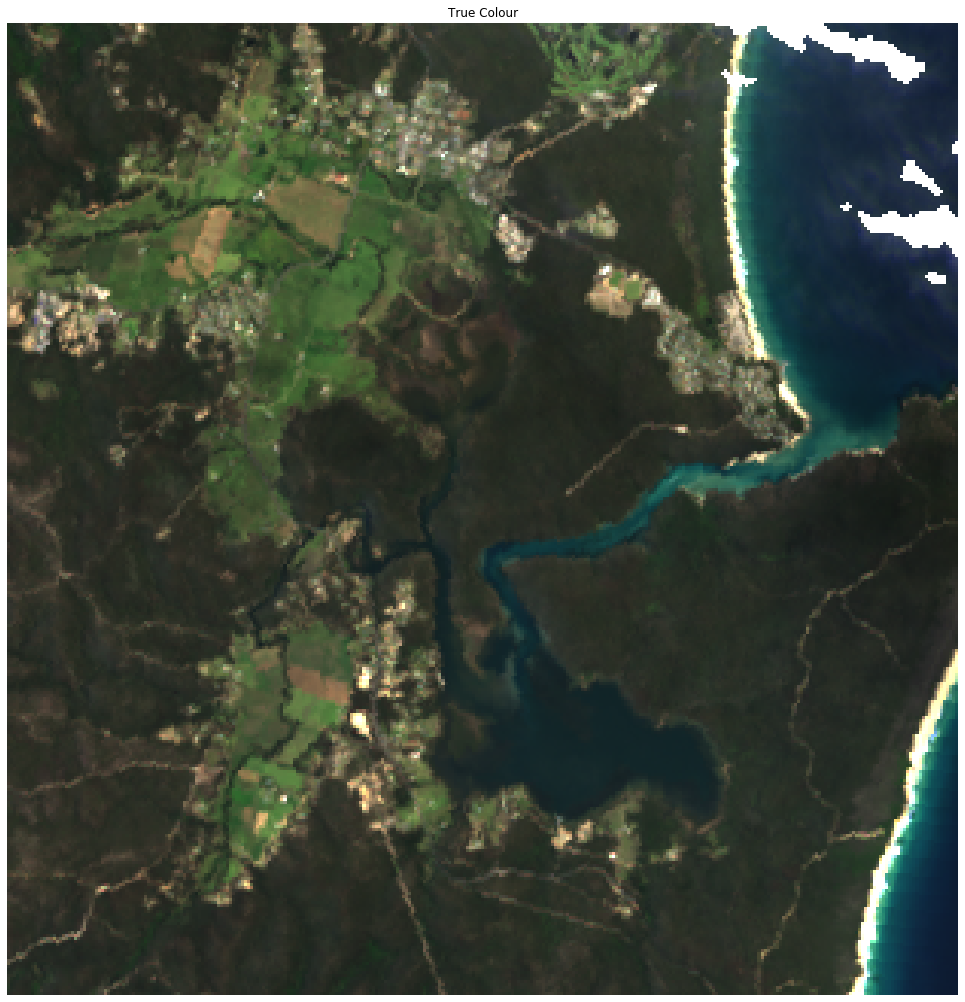

In [9]:
data_lst8_once = Masked_lst8_data.isel(time=2)

#Prepare geomedian imagery for plotting

rgb = data_lst8_once.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(15,15)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('True Colour') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [10]:
#Do tassled Cap transformation
TCI = TasseledCapTools.thresholded_tasseled_cap(Masked_lst8_data,wetness_threshold=-1200, drop=True
                                                , drop_tc_bands=False)
tcw = TCI['wetness']




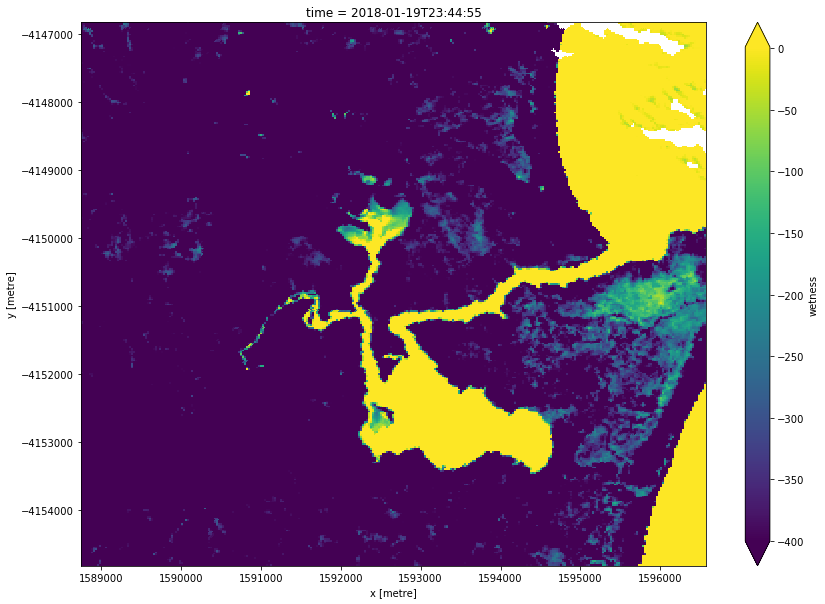

In [11]:
tcw.isel(time=2).plot(cmap='viridis', figsize =(14,10),vmin=-400, vmax=1)

In [12]:
#make Fisher index

lst_fisher = 1.7204 +((171*Masked_lst8_data['green'])+(3*Masked_lst8_data['red'])-(70*Masked_lst8_data['nir'])-(45*Masked_lst8_data['swir1'])-(71*Masked_lst8_data['swir2']))/10000
lst_fisher

<xarray.DataArray (time: 46, y: 320, x: 313)>
array([[[-19.8673, -19.0042, ...,   3.4124,   3.4053],
        [-22.7548, -19.6263, ...,   3.4028,   3.4387],
        ...,
        [-17.559 , -14.5333, ...,   3.3831,   3.3896],
        [-14.1751, -13.5119, ...,   3.4131,   3.3668]],

       [[-17.0632,      nan, ...,   3.4348,   3.7016],
        [-17.5758,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,   2.7752,      nan],
        [     nan,      nan, ...,   2.5499,   2.7642]],

       ...,

       [[-21.9497, -20.0292, ...,      nan,      nan],
        [-23.3008, -19.2855, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,   2.9626],
        [     nan,      nan, ...,   2.6801,   2.9066]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]]])
C

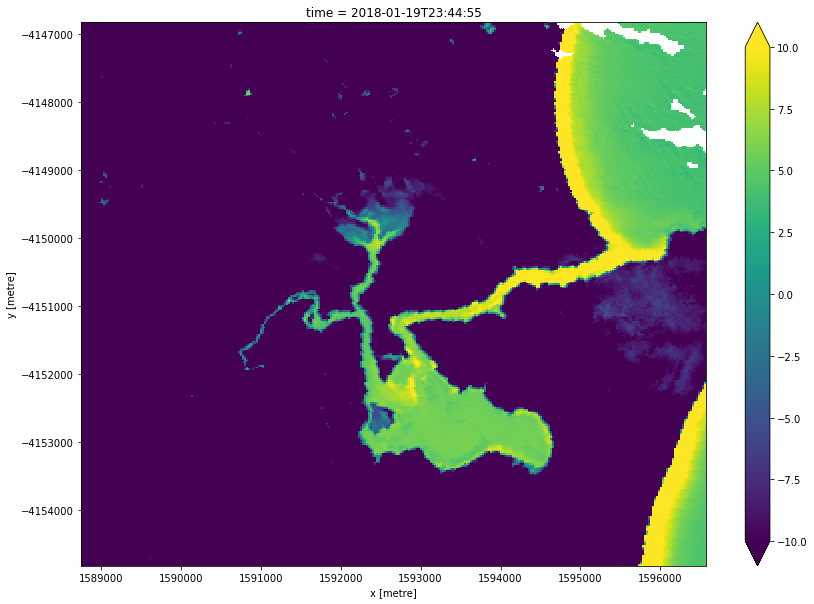

In [13]:
lst_fisher.isel(time=2).plot(cmap='viridis', figsize =(14,10),vmin=-10,)

In [14]:
inundated_veg_msk = (np.logical_and(lst_fisher>=-10,tcw>=-350))
inundated_veg = lst_fisher.where(inundated_veg_msk==True,0)
inundated_veg = inundated_veg.where(inundated_veg_msk==False,1)

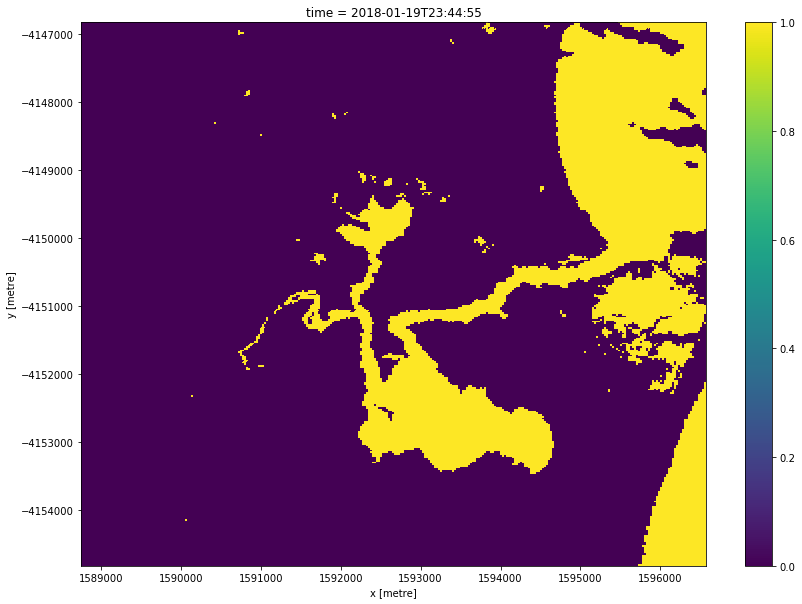

In [15]:
inundated_veg.isel(time=2).plot(cmap='viridis', figsize =(14,10))

In [16]:
wet_frequency = inundated_veg.sum(dim='time')

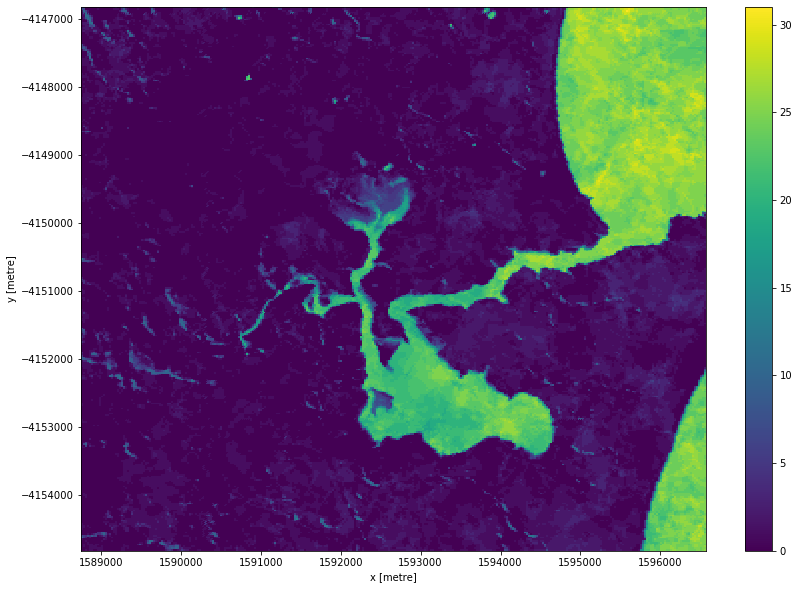

In [17]:
wet_frequency.plot(cmap='viridis', figsize =(14,10))

In [18]:
precent_threhold = total_obs*0.1
precent_threhold

4.6000000000000005

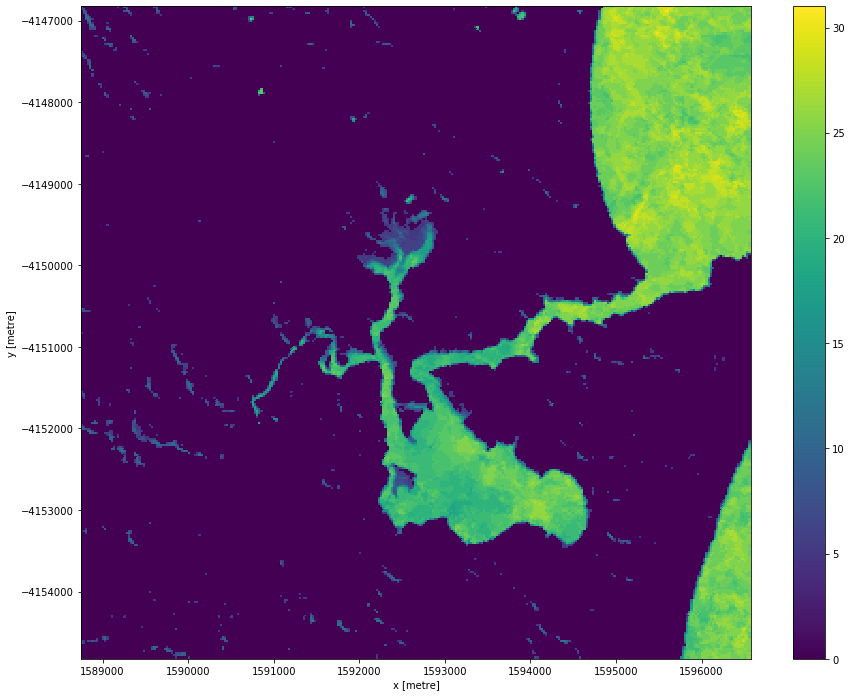

In [19]:
persistant_wet = wet_frequency.where(wet_frequency>precent_threhold,0)

persistant_wet.plot(figsize =(15,12))

In [20]:
Masked_lst8_data

<xarray.Dataset>
Dimensions:          (time: 46, x: 313, y: 320)
Coordinates:
  * time             (time) datetime64[ns] 2018-01-03T23:45:03 ... 2018-12-28T23:50:34
  * y                (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x                (x) float64 1.589e+06 1.589e+06 ... 1.597e+06 1.597e+06
Data variables:
    coastal_aerosol  (time, y, x) float64 251.0 294.0 327.0 ... nan nan nan
    blue             (time, y, x) float64 175.0 222.0 245.0 ... nan nan nan
    green            (time, y, x) float64 297.0 327.0 340.0 ... nan nan nan
    red              (time, y, x) float64 190.0 225.0 258.0 ... nan nan nan
    nir              (time, y, x) float64 2.713e+03 2.529e+03 ... nan nan
    swir1            (time, y, x) float64 1.002e+03 1.167e+03 ... nan nan
    swir2            (time, y, x) float64 454.0 483.0 552.0 ... nan nan nan
Attributes:
    crs:      EPSG: 3577

In [21]:
Data_out = Masked_lst8_data.drop(['coastal_aerosol','nir','swir1','swir2'])
#Data_out['inundated_veg'] = inundated_veg.astype('float64')
Data_out

<xarray.Dataset>
Dimensions:  (time: 46, x: 313, y: 320)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-03T23:45:03 ... 2018-12-28T23:50:34
  * y        (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x        (x) float64 1.589e+06 1.589e+06 1.589e+06 ... 1.597e+06 1.597e+06
Data variables:
    blue     (time, y, x) float64 175.0 222.0 245.0 239.0 ... nan nan nan nan
    green    (time, y, x) float64 297.0 327.0 340.0 304.0 ... nan nan nan nan
    red      (time, y, x) float64 190.0 225.0 258.0 261.0 ... nan nan nan nan
Attributes:
    crs:      EPSG: 3577

In [22]:
Data_out_once = Data_out.isel(time=2)
Data_out_once['inundated_veg']=persistant_wet.astype('float64')
Data_out_once

<xarray.Dataset>
Dimensions:        (x: 313, y: 320)
Coordinates:
    time           datetime64[ns] 2018-01-19T23:44:55
  * y              (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x              (x) float64 1.589e+06 1.589e+06 ... 1.597e+06 1.597e+06
Data variables:
    blue           (y, x) float64 233.0 282.0 297.0 317.0 ... 384.0 388.0 382.0
    green          (y, x) float64 366.0 378.0 358.0 364.0 ... 214.0 211.0 214.0
    red            (y, x) float64 220.0 270.0 258.0 307.0 ... 103.0 105.0 105.0
    inundated_veg  (y, x) float64 9.0 0.0 0.0 0.0 0.0 ... 25.0 24.0 25.0 26.0
Attributes:
    crs:      EPSG: 3577

In [23]:
#write_geotiff(filename, dataset, profile_override=None, time_index=None)
#write_geotiff('/g/data/u46/users/ck9738/Datasets/Tasselled_cap_tifs/Tuross_heads_tassel_wi_fisher_2018_stacked.tif',Data_out_once)